In [12]:
import json
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import contextily as ctx
#import folium
#from folium.plugins import Search
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
#from skimage.transform import resize
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.font_manager as fm
from PIL import Image
from matplotlib.lines import Line2D

In [2]:
#Kriti_left_final/kriti_left_final.shp
#korinthos_right/Korinthos_right_smooth_diss_2024.shp
#greece-latest-free-shp/gis_osm_places_free_1.shp
#χιοσ/XIOS_polygon.shp

In [2]:
import geopandas as gpd

# Load the shapefile
# shapefile_path = 'korinthos_right/Korinthos_right_smooth_diss_2024.shp'  # Ensure all components are present in this directory
# shapefile = gpd.read_file(shapefile_path)
# shapefile_path = 'greece-latest-free-shp/gis_osm_places_free_1.shp'  # Ensure all components are present in this directory
# shapefile = gpd.read_file(shapefile_path)
# shapefile_path = 'oikismoi/f45c73bd-d733-4fe0-871b-49f270c56a75.shp'  # Ensure all components are present in this directory
# shapefile = gpd.read_file(shapefile_path)
shapefile_path = 'falakro/dNBR_Karaflo_17_07_mask_0-15_diss_smooth.shp'  # Ensure all components are present in this directory
shapefile = gpd.read_file(shapefile_path)

# Print column names
#print(shapefile[shapefile['fclass'].isin(['city', 'village', 'town'])])
print(shapefile)

       fid  DN  area_ha                                           geometry
0  19799.0   1      223  MULTIPOLYGON (((417891.173 4179285.369, 417896...


C:\Users\alkki\AppData\Local\Temp\ipykernel_3372\3449403720.py:53: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  bounded_shapefile2.plot(ax=ax, edgecolor='black', facecolor='white', markersize=50, alpha=1, marker='o', legend=True)


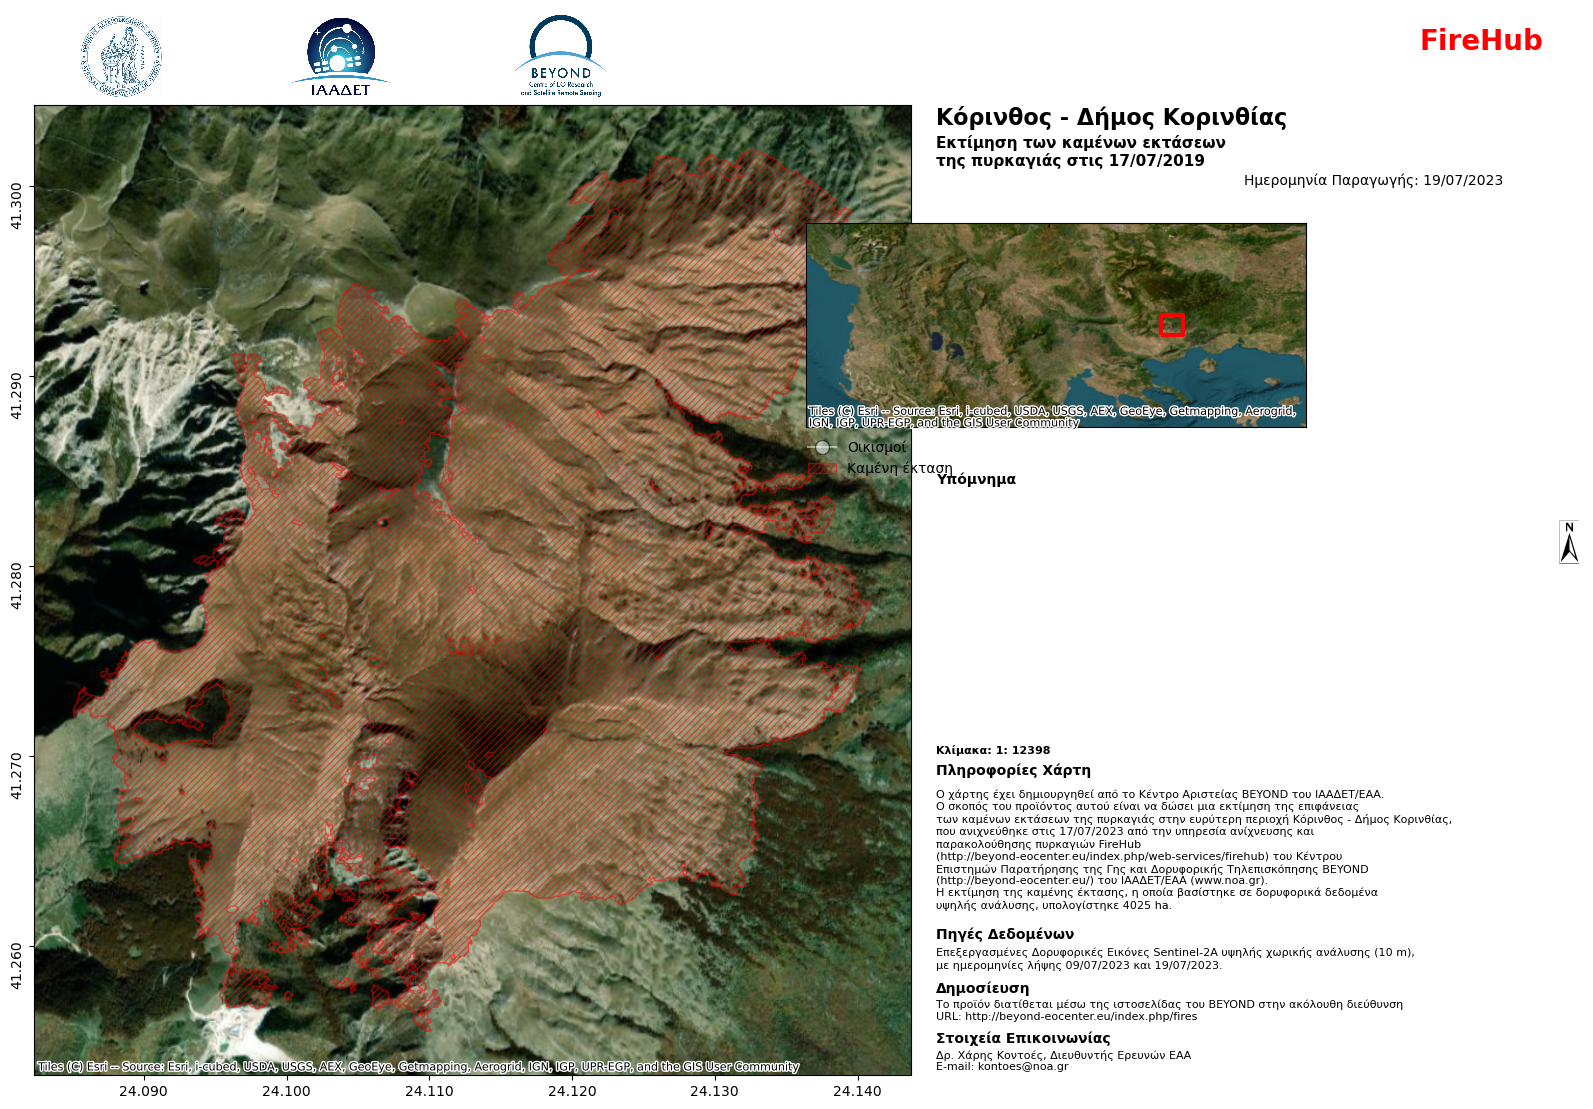

In [11]:
# Load the configuration from the JSON file
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

# Change these inputs in config.json
shapefile1_path = config['shapefile1_path']
shapefile2_path = config['shapefile2_path']
place = config['place']
detect = config['detect_date']
area = config['area'] #ha
product = config['product']
rawdate = config['raw_dates']
mapdate = config['map_date']
north_logo_path = config['north_logo_path']
first_logo_path = config['first_logo_path']
second_logo_path = config['second_logo_path']
third_logo_path = config['third_logo_path']
burned_map_path = config['burned_map_path']
cropped_burned_map_path = config['cropped_burned_map_path']

# Load the shapefiles
shapefile1 = gpd.read_file(shapefile1_path)
shapefile2 = gpd.read_file(shapefile2_path)

# Set and reproject CRS
shapefile1.crs = 'EPSG:2100'
shapefile2.crs = 'EPSG:4326'
shapefile1 = shapefile1.to_crs(epsg=4326)  # Reproject in WGS84
shapefile2 = shapefile2.to_crs(epsg=4326)  # Reproject in WGS84

# Get the bounding box of the larger shapefile
x_min, y_min, x_max, y_max = shapefile1.total_bounds
width = x_max - x_min
height = y_max - y_min

# Optionally adjust the bounding box size
expansion_factor = 0.5  #adjust this for zoom
x_min -= width * expansion_factor
x_max += width * expansion_factor
y_min -= height * expansion_factor
y_max += height * expansion_factor

# Create a polygon for the bounding box
bbox_polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max), (x_min, y_min)])
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_polygon]}, crs=shapefile1.crs)

# Filter shapefile2 to only include points within the bounding box of shapefile1
bounded_shapefile2 = shapefile2[shapefile2.geometry.within(bbox_polygon)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
shapefile1.plot(ax=ax, edgecolor='red', facecolor='none', alpha=0.5, hatch='/////', legend=True)
bounded_shapefile2.plot(ax=ax, edgecolor='black', facecolor='white', markersize=50, alpha=1, marker='o', legend=True)

# Annotate the names of the areas
for idx, row in bounded_shapefile2.iterrows():
    plt.annotate(text=row['name'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), xytext=(3, 3), textcoords='offset points', fontsize=8, color='white') # change name according to column name of the settlements

# Add the satellite basemap using contextily
ctx.add_basemap(ax, crs=shapefile1.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.tight_layout()

# Set the coordinates to be displayed vertically
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='y', rotation=90)

# Set the format for the coordinates
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.3f}'))

# Calculate the horizontal scale (in meters) based on the map extent
scale_x = (x_max - x_min) * 111000  # Approximate value for longitude in meters at the equator
# Calculate the vertical scale (in meters) based on the map extent
scale_y = (y_max - y_min) * 111000  # Approximate value for latitude in meters
# Determine the appropriate scale value based on the map extent
scale = max(scale_x, scale_y)
# Choose the units you want to display for the scale (e.g., meters or kilometers)
scale_units = "μέτρο"
# Add scale to the plot as text
scale_text = f"Κλίμακα: 1: {scale:.0f}"

######NEW

# Create the inset map showing the area of interest (AOI)
# shapefile1 = shapefile1.to_crs(epsg=4326)
# x_min, y_min, x_max, y_max = shapefile1.total_bounds
# width = x_max - x_min
# height = y_max - y_min
expansion_factor = 30  #adjust this value as needed to control the size of the AOI
x_min_ = x_min + (width * expansion_factor)
x_max_ = x_max - (width * 3 * expansion_factor)
y_min_ = y_min + (height * expansion_factor)
y_max_ = y_max - (height * expansion_factor)

aoi_polygon = Polygon([(x_min-0.1, y_min-0.1), (x_max+0.1, y_min-0.1), (x_max+0.1, y_max+0.1), (x_min-0.1, y_max+0.1)]) #adjust size of red square
aoi_polygon_ = Polygon([(x_min_, y_min_), (x_max_, y_min_), (x_max_, y_max_), (x_min_, y_max_)])
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_polygon], crs=shapefile1.crs)
aoi_gdf_ = gpd.GeoDataFrame(geometry=[aoi_polygon_], crs=shapefile1.crs)

# Adjust the coordinates for the inset to be placed under the title
inset_ax = fig.add_axes([0.859, 0.515, 0.5, 0.5])  #adjusted coordinates of smaller map
aoi_gdf_.plot(ax=inset_ax, edgecolor='red', facecolor='none', alpha=0, legend=True)
aoi_gdf.plot(ax=inset_ax, edgecolor='red', facecolor='none', alpha=1, linewidth=3, legend=True)
ctx.add_basemap(inset_ax, crs=shapefile1.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')

##########

# Add logo
#logo = plt.imread('C:\\Users\\User\\Documents\\Projects_2022\\FireHub_FireMapping_Summer\\FB TIMELINE 1200X675.jpg')
#ax.imshow(logo, extent=(0.8, 1, 0.8, 1), transform=ax.transAxes)
#small_logo = resize(logo, (200, 200)) # resize logo to 200x200 pixels

#Add title
plt.text(1.58, 1.08, "FireHub", transform=ax.transAxes, rotation=0, va='top', fontweight='bold', fontsize=20, color='red') #adjust for position of FireHub

xtext = 1.029 #adjust for position of some text on the x axis
ytext = 0 #adjust for position of some text on the y axis

# Add legend
plt.text(xtext, 0.61, "Υπόμνημα", transform=ax.transAxes, rotation=0, ha='left', va='baseline', fontweight='bold', fontsize=10) #adjust for position of "Υπόμνημα"
bbox_gdf.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0, legend=True) 
plt.plot(shapefile1['fid'], label='Καμένη έκταση') #adjust id according to id of the burned area
plt.plot(bounded_shapefile2['osm_id'], label='Οικισμοί') #adust id according to id of the settlements
fire = mpatches.Patch(edgecolor='red', facecolor='none', alpha=0.5, hatch='/////', label='Καμένη έκταση')
settlement = Line2D([0], [0], marker='o', color='w', label='Οικισμοί', markerfacecolor='white', markeredgecolor='black', markersize=10, alpha=0.5)
legend = plt.legend(loc='right', title_fontproperties=fm.FontProperties(weight='bold'), bbox_to_anchor=(0.305, -0.15), borderaxespad=0, frameon=False, handles=[settlement, fire]) #adjust for position of ypomnima values
# plt.setp(legend.get_title(), position=(-33.5, 0))  # Adjust this to move the title

# Create a location map showing the full extent of the data
#https://mohammadimranhasan.com/geospatial-data-mapping-with-python/
#a=inset_axes(shapefile1, width="30%", height='30%',loc='lower right')
#shapefile1.plot(figsize=(20,20), cmap='PuOr',ax=a)
#a.text(x=88.6, y=22.25, s='Study Area', fontsize=10)
#a.plot([88.9, 90, 90, 88.9, 88.9],[21.5, 21.5, 23, 23,21.5], lw=2)

# Add standardised text on the side of the map
#ax.set_title(place, rotation=0, position=(1.029, 0), ha='left', va='baseline', fontweight='bold')
#adjust everything for position of text
plt.text(xtext, 0.98, place, transform=ax.transAxes, rotation=0, ha='left', va='baseline', fontweight='bold', fontsize=16)
subtitle = 'Εκτίμηση των καμένων εκτάσεων\nτης πυρκαγιάς στις 17/07/2019' 
plt.text(xtext, 0.97, subtitle, transform=ax.transAxes, fontsize=11, va='top', fontweight='bold')
date_of_map = 'Ημερομηνία Παραγωγής: ' + mapdate
plt.text(1.38, 0.93, date_of_map, transform=ax.transAxes, fontsize=10, va='top')
plt.text(xtext, ytext + 0.335, scale_text, transform=ax.transAxes, fontsize=8, va='center', fontweight='bold')
info_title1 = 'Πληροφορίες Χάρτη'
plt.text(xtext, ytext + 0.314, info_title1, transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
info1 = ('Ο χάρτης έχει δημιουργηθεί από το Κέντρο Αριστείας BEYOND του ΙΑΑΔΕΤ/ΕΑΑ.\n'
         'O σκοπός του προϊόντος αυτού είναι να δώσει μια εκτίμηση της επιφάνειας\n'
         'των καμένων εκτάσεων της πυρκαγιάς στην ευρύτερη περιοχή '+place+ ',\n'
         'που ανιχνεύθηκε στις '+detect+' από την υπηρεσία ανίχνευσης και\n'
         'παρακολούθησης πυρκαγιών FireHub\n'
         '(http://beyond-eocenter.eu/index.php/web-services/firehub) του Κέντρου\n'
         'Επιστημών Παρατήρησης της Γης και Δορυφορικής Τηλεπισκόπησης BEYOND\n'
         '(http://beyond-eocenter.eu/) του ΙΑΑΔΕΤ/ΕΑΑ (www.noa.gr).\n'
         'Η εκτίμηση της καμένης έκτασης, η οποία βασίστηκε σε δορυφορικά δεδομένα\n'
         'υψηλής ανάλυσης, υπολογίστηκε '+area+' ha.')
plt.text(xtext, ytext + 0.232, info1, transform=ax.transAxes, fontsize=8, va='center')
info_title2 = 'Πηγές Δεδομένων'
plt.text(xtext, ytext + 0.145, info_title2, transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
info2 = product+',\nμε ημερομηνίες λήψης '+rawdate+'.'
plt.text(xtext, ytext + 0.12, info2, transform=ax.transAxes, fontsize=8, va='center')
info_title3 = 'Δημοσίευση'
plt.text(xtext, ytext + 0.09, info_title3, transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
info3 = ('Το προϊόν διατίθεται μέσω της ιστοσελίδας του BEYOND στην ακόλουθη διεύθυνση\n'
         'URL: http://beyond-eocenter.eu/index.php/fires')
plt.text(xtext, ytext + 0.067, info3, transform=ax.transAxes, fontsize=8, va='center')
info_title4 = 'Στοιχεία Επικοινωνίας'
plt.text(xtext, ytext + 0.038, info_title4, transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
info4 = 'Δρ. Χάρης Κοντοές, Διευθυντής Ερευνών ΕΑΑ\nE-mail: kontoes@noa.gr'
plt.text(xtext, ytext + 0.015, info4, transform=ax.transAxes, fontsize=8, va='center')

# Add north
logo_image = plt.imread(north_logo_path)
logo_plot = OffsetImage(logo_image, zoom=0.7)  #adjust zoom to control logo size
ab = AnnotationBbox(logo_plot, (1.75, 0.55), xycoords='axes fraction', frameon=False) #adjust position of north arrow
ax.add_artist(ab)

# x, y, arrow_length = 1.9, 0.6, 0.1
# ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='top', fontsize=20,
#             xycoords=ax.transAxes)

# logo_path = 'logos\BEYOND_LOGO.png'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.03)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.030, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

# logo_path = 'logos\IAADET.jpeg'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.09)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.015, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

# logo_path = 'logos\AsteroskopoioLogoOuranidon.png'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.1)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.002, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

#######NEWNEW

# Add logos to the plot
logo_paths = [
    (first_logo_path, 0.185),
    (second_logo_path, 0.08),
    (third_logo_path, 0.123)
]

# Adjusted coordinates for logos placed side by side
for i, (logo_path, zoom) in enumerate(logo_paths):
    logo_image = plt.imread(logo_path)
    logo_plot = OffsetImage(logo_image, zoom=zoom)
    ab = AnnotationBbox(logo_plot, (0.1 + i*0.25, 1.05), xycoords='axes fraction', frameon=False) #adjust position of logos
    ax.add_artist(ab)

#########

# Save the figure
plt.savefig(burned_map_path, dpi=125, bbox_inches='tight')

# Show the plot
plt.show()

# Close the figure to release memory
plt.close(fig)

# Load the image
image = Image.open(burned_map_path)

# Get the dimensions of the original image
width, height = image.size

# Define the crop area
left = 0       # Keep the left side as is
upper = 0      # Keep the top side as is
right = width - 300  # Crop 100 pixels from the right
lower = height  # Keep the bottom side as is

# Crop the image
cropped_image = image.crop((left, upper, right, lower))

# Save the cropped image
cropped_image.save(cropped_burned_map_path)

# Optionally, show the cropped image
cropped_image.show()
